In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO

import bayesreg_pyro as br

In [3]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()

In [4]:
# sns.pairplot(data)
# plt.show()

In [39]:
# prepare data
y_data = torch.Tensor(data["Bodyfat"].values)
x_data = torch.Tensor(data.drop("Bodyfat", axis=1).values)
in_features = x_data.shape[1]

In [40]:
model = br.BayesianRegression(in_features, 1)
guide = AutoDiagonalNormal(model) # Stochastic Mean field
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())


In [41]:
torch.manual_seed(1)
pyro.clear_param_store()
elbos, samples = br.run_vi(x_data, y_data, svi, model, guide)
samples["linear.weight"] = samples["linear.weight"].reshape(-1, in_features)

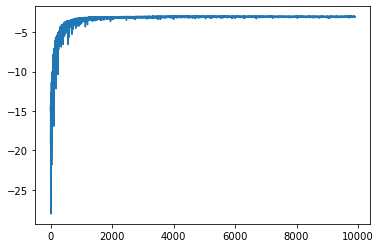

In [43]:
plt.plot(elbos[100:])
plt.show()

In [32]:
guide.requires_grad_(False)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

linear.bias Parameter containing:
tensor([7.5992e-05], requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([ 1.4628e+00,  7.6286e-02, -9.9085e-02, -1.0168e-01, -4.9859e-01,
        -2.2206e-02,  9.5444e-01, -2.0454e-01,  2.3152e-01, -9.6748e-04,
         1.5979e-01,  1.6169e-01,  4.0038e-01, -1.2672e+00])
AutoDiagonalNormal.scale tensor([0.0439, 0.0286, 0.0085, 0.0877, 0.1065, 0.0390, 0.0307, 0.0413, 0.0473,
        0.1242, 0.1479, 0.0903, 0.1259, 0.3164])


In [44]:
# VI results -- calculated from posterior samples
pd.DataFrame({
    "loc": samples["linear.weight"].mean(axis=0),
    "scale": samples["linear.weight"].std(axis=0),
}, index= list(data.drop("Bodyfat", axis=1).columns)).pipe(lambda df: np.round(df, 2))




,loc,scale
Age,0.04,0.02
Weight,-0.10,0.01
Height,-0.09,0.08
Neck,-0.48,0.12
Chest,-0.03,0.03
Abdomen,0.95,0.03
Hip,-0.20,0.05
Thigh,0.24,0.05
Knee,0.01,0.12
Ankle,0.13,0.15


In [11]:
hmc_samples = br.run_hmc(x_data, y_data, model)

Sample: 100%|██████████| 1200/1200 [01:18, 15.24it/s, step size=1.09e-01, acc. prob=0.944]


In [12]:
# HMC results
pd.DataFrame({
    "loc": hmc_samples["linear.weight"].mean(axis=0),
    "scale": hmc_samples["linear.weight"].std(axis=0),
}, index= list(data.drop("Bodyfat", axis=1).columns)).pipe(lambda df: np.round(df, 2))

,loc,scale
Age,0.05,0.03
Weight,-0.09,0.05
Height,-0.08,0.10
Neck,-0.49,0.22
Chest,-0.02,0.09
Abdomen,0.96,0.08
Hip,-0.20,0.15
Thigh,0.23,0.15
Knee,0.01,0.24
Ankle,0.13,0.22


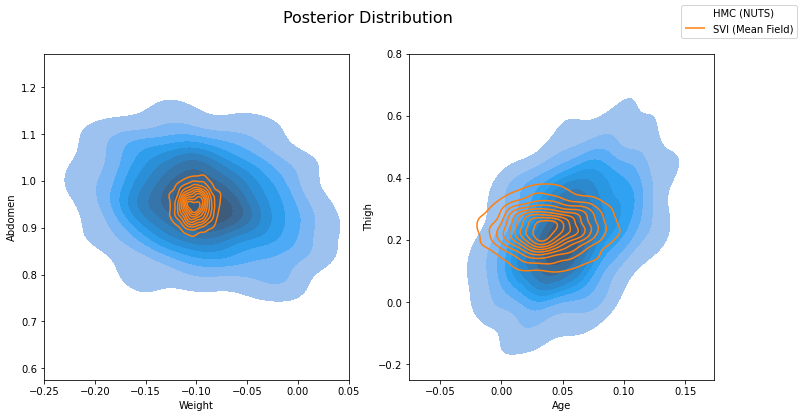

In [45]:
# compare HMC vs VI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Posterior Distribution", fontsize=16)

sns.kdeplot(x=hmc_samples["linear.weight"][:,1], y=hmc_samples["linear.weight"][:,5], ax=axs[0], shade=True, label="HMC (NUTS)")
sns.kdeplot(x=samples["linear.weight"][:,1], y=samples["linear.weight"][:,5], ax=axs[0], label="SVI (Mean Field)")
axs[0].set(xlabel="Weight", ylabel="Abdomen",  xlim=(-0.25, 0.05),)

sns.kdeplot(x=hmc_samples["linear.weight"][:, 0], y=hmc_samples["linear.weight"][:,7], ax=axs[1], shade=True, label="HMC (NUTS)")
sns.kdeplot(x=samples["linear.weight"][:, 0], y=samples["linear.weight"][:,7], ax=axs[1], label="SVI (Mean Field)")
axs[1].set(xlabel="Age", ylabel="Thigh", ylim=(-0.25, 0.8))


handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [24]:
# Run non mean-field
torch.manual_seed(12)
pyro.clear_param_store()

guide_mvt = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi_mvt = SVI(model, guide_mvt, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

elbos_mvt, samples_mvt = br.run_vi(x_data, y_data, svi_mvt, model, guide_mvt)
samples_mvt["linear.weight"] = samples_mvt["linear.weight"].reshape(-1, in_features)

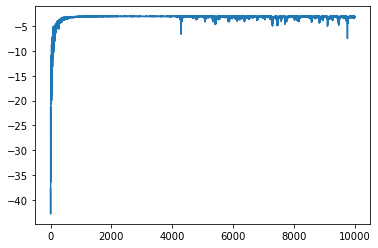

In [26]:
plt.plot(elbos_mvt[10:])

In [27]:
# non-mean field VI results
np.round(pd.DataFrame(
    {
        "loc": samples_mvt["linear.weight"].mean(axis=0),
        "scale": samples_mvt["linear.weight"].std(axis=0),
    }, list(data.drop("Bodyfat", axis=1).columns)), 2)

,loc,scale
Age,0.05,0.04
Weight,-0.10,0.05
Height,-0.11,0.13
Neck,-0.48,0.25
Chest,-0.01,0.11
Abdomen,0.96,0.10
Hip,-0.19,0.17
Thigh,0.25,0.15
Knee,0.02,0.28
Ankle,0.09,0.22


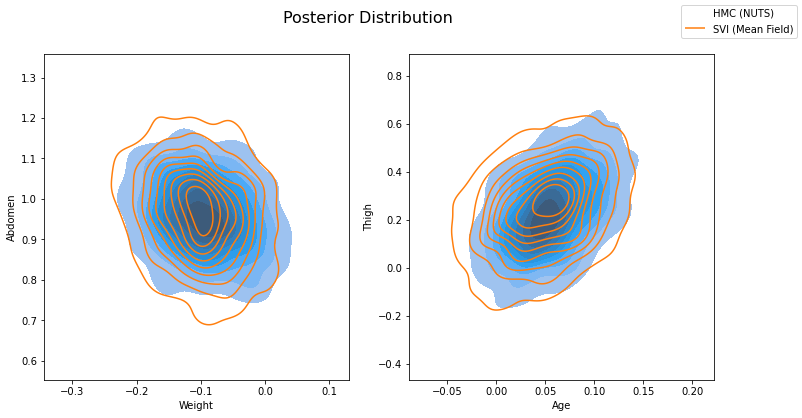

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Posterior Distribution", fontsize=16)

sns.kdeplot(x=hmc_samples["linear.weight"][:,1], y=hmc_samples["linear.weight"][:,5], ax=axs[0], fill=True, label="HMC (NUTS)")
sns.kdeplot(x=samples_mvt["linear.weight"][:,1], y=samples_mvt["linear.weight"][:,5], ax=axs[0], label="SVI (Mean Field)")
axs[0].set(xlabel="Weight", ylabel="Abdomen", )

sns.kdeplot(x=hmc_samples["linear.weight"][:, 0], y=hmc_samples["linear.weight"][:,7], ax=axs[1], fill=True, label="HMC (NUTS)")
sns.kdeplot(x=samples_mvt["linear.weight"][:, 0], y=samples_mvt["linear.weight"][:,7], ax=axs[1], label="SVI (Mean Field)")
axs[1].set(xlabel="Age", ylabel="Thigh", )


handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()